# 千葉県内の自転車盗難について

In [22]:
import pandas as pd

bike=pd.read_csv('bikecycle.csv')
print(bike.head())   

   罪名    手口 管轄警察署（発生地） 管轄交番・駐在所（発生地）  市区町村コード（発生地） 都道府県（発生地） 市区町村（発生地）  \
0  窃盗  自転車盗       千葉中央         千葉寺駅前      121011.0       千葉県    千葉市中央区   
1  窃盗  自転車盗       千葉中央         千葉寺駅前      121011.0       千葉県    千葉市中央区   
2  窃盗  自転車盗       千葉中央         千葉寺駅前      121011.0       千葉県    千葉市中央区   
3  窃盗  自転車盗       千葉中央         千葉寺駅前      121011.0       千葉県    千葉市中央区   
4  窃盗  自転車盗       千葉中央         千葉寺駅前      121011.0       千葉県    千葉市中央区   

  町丁目（発生地） 発生年月日（始期） 発生時（始期）                 発生場所 発生場所の詳細 被害者の年齢 被害者の職業  施錠関係  
0      青葉町  20240117      23  その他の住宅（３階建て以下共同住宅等）  駐車（輪）場   20歳代    大学生  施錠した  
1      青葉町  20240227      18               駐車（輪）場  駐車（輪）場   10歳代    中学生  施錠せず  
2      青葉町  20240528      20               駐車（輪）場  駐車（輪）場   40歳代    その他  施錠した  
3      青葉町  20240627      21               駐車（輪）場  駐車（輪）場   10歳代    中学生  施錠せず  
4      青葉町  20240917      14                  その他     その他   20歳代    その他  施錠せず  


### 地域ごとの分析


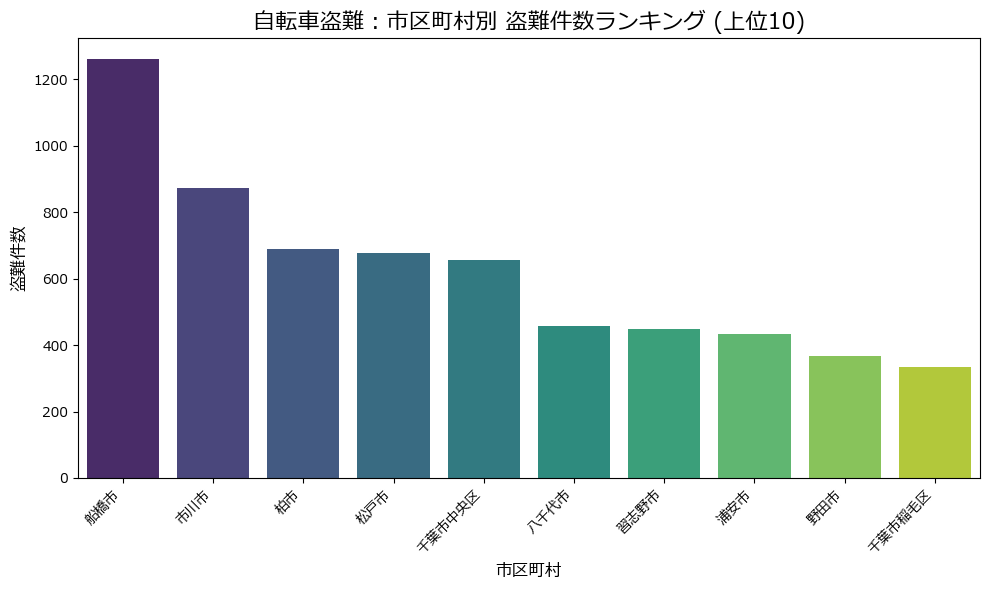

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# --- 日本語設定 ---
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['axes.unicode_minus'] = False

# CSVファイルを読み込み、dfを定義する 
df = pd.read_csv("bikecycle.csv")

# 市区町村別の件数を集計し、降順でソート
city_ranking = df['市区町村（発生地）'].value_counts().head(10)

# グラフの描画
plt.figure(figsize=(10, 6))

# ★修正点: FutureWarning対策として、明示的に hue=city_ranking.index を指定し、paletteを使う
# 'hue'を指定しないと将来的にpaletteが機能しなくなるという警告を回避します。
sns.barplot(x=city_ranking.index, y=city_ranking.values, hue=city_ranking.index, palette='viridis', legend=False)

# ★修正点: UserWarning (絵文字未対応) 対策として、タイトルから絵文字 (📍) を削除
plt.title('自転車盗難：市区町村別 盗難件数ランキング (上位10)', fontsize=16) 
plt.xlabel('市区町村', fontsize=12)
plt.ylabel('盗難件数', fontsize=12)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

まず、表を使ってどの地域に自転車盗難が多いかを求めました。最も多いのは船橋市で、次点で市川市であるため地域的にはかなり固まっているのではないのかと推測しました。

### 時間帯別の分析

C:\Users\gatai\AppData\Local\Temp\ipykernel_17100\1434908227.py:52: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\gatai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) Meiryo.
  fig.canvas.print_figure(bytes_io, **kw)


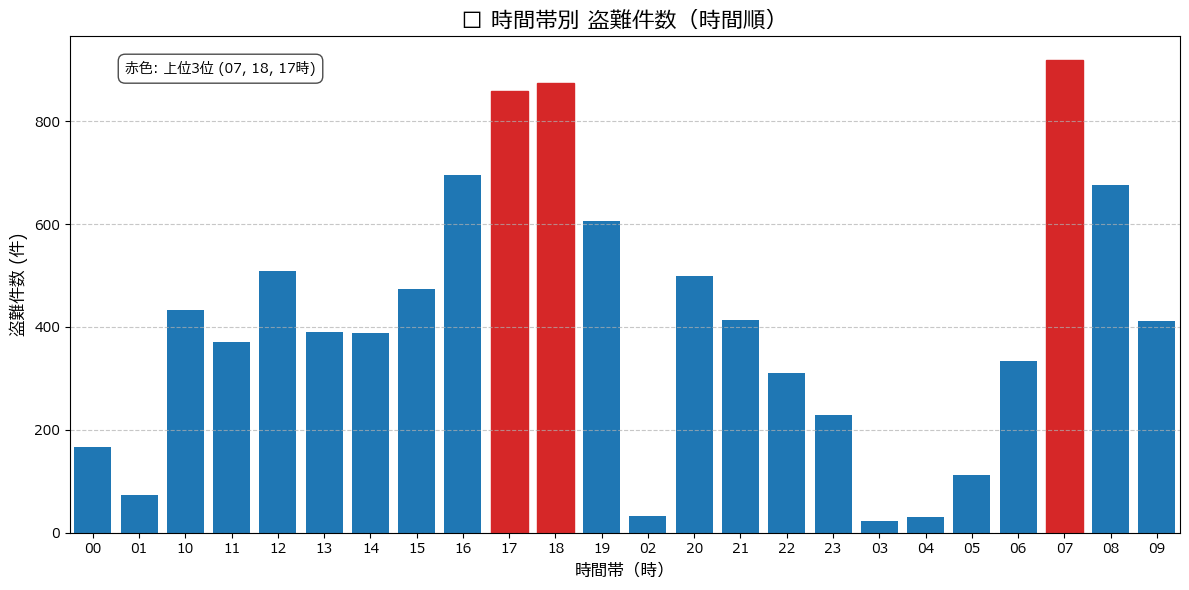

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 日本語表示のための設定
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['axes.unicode_minus'] = False

# 1. '発生時（始期）'で件数を集計し、数値（時間）順にソート
time_counts = df.groupby('発生時（始期）').size().reset_index(name='件数')
# 発生時（始期）は0〜23の数値なので、この列でソートすれば時間順になります。
time_counts = time_counts.sort_values(by='発生時（始期）').reset_index(drop=True)

# 2. '時間帯（時）'を文字列（2桁ゼロ埋め）に変換
time_counts['時間帯（時）'] = time_counts['発生時（始期）'].astype(str).str.zfill(2)

# 3. グラフの作成
plt.figure(figsize=(12, 6))

# X軸の位置を、ソートされたデータフレームの数値（0, 1, 2, ..., 23）から取得
x_positions = time_counts['発生時（始期）'].tolist() # [0, 1, 2, ..., 23]
x_labels = time_counts['時間帯（時）'].tolist() # ['00', '01', '02', ..., '23']

# 棒グラフを作成
# X軸に数値（0〜23）を渡し、matplotlibに数値データとして扱わせる
bars = plt.bar(x_positions, time_counts['件数'], width=0.8, color='#1f77b4')

# ★最終修正点: 目盛りの位置(ticks)を数値(0-23)に、ラベルを文字列('00'-'23')に設定し、対応を固定
plt.xticks(x_positions, x_labels, rotation=0)

# 件数が多い上位3つの棒の色を変更し、強調
top_3_indices = time_counts['件数'].nlargest(3).index
top_3_hours = time_counts.loc[top_3_indices]['時間帯（時）'].tolist()

# グラフ上の棒を一つずつチェックし、上位3位であれば色を変更
# X軸の値は数値(0-23)になっているため、time_countsのインデックスではなく'発生時（始期）'の値を使用
for i, (hour_num, count) in time_counts[['発生時（始期）', '件数']].iterrows():
    hour_str = str(hour_num).zfill(2)
    if hour_str in top_3_hours:
        # hour_numは0から23なので、barsのインデックスとしてそのまま使用できる
        bars[i].set_color('#d62728') # 赤色に変更

plt.title('🕒 時間帯別 盗難件数（時間順）', fontsize=16)
plt.xlabel('時間帯（時）', fontsize=12)
plt.ylabel('盗難件数 (件)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-0.5, 23.5) # X軸の範囲を0-23の目盛りが中央に来るように設定

# グラフ上に凡例を表示
plt.text(0.05, 0.95, f'赤色: 上位3位 ({", ".join(top_3_hours)}時)', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7))

plt.tight_layout()
plt.show()

次に自転車盗難が多い時間帯について調べてみました。最も多いのは、夕方の時間帯でした。
なぜか時間順に並べるのができませんでした。

### 施錠との関係について

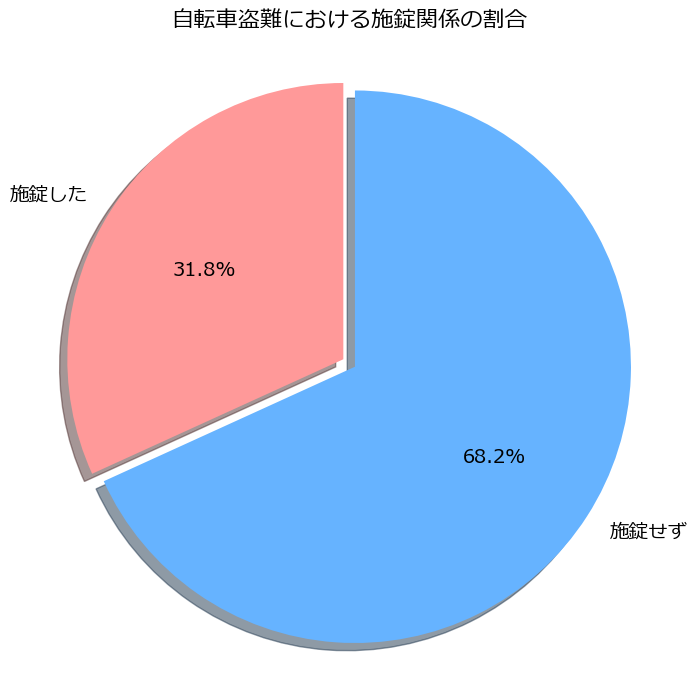

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 日本語表示のための設定
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['axes.unicode_minus'] = False

# ファイルの読み込みとデータ準備 (dfが既にメモリにあることを前提)

# 1. '施錠関係'で件数を集計
lock_counts = df.groupby('施錠関係').size().reset_index(name='件数')

# 2. 円グラフの作成
plt.figure(figsize=(8, 8))

# ラベルとデータ
labels = lock_counts['施錠関係']
sizes = lock_counts['件数']

# 色の設定
colors = ['#ff9999', '#66b3ff'] # '施錠せず'を赤系、'施錠した'を青系に設定
explode = [0.05, 0] # '施錠せず'のピースを少し分離して強調

# 円グラフの描画
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%', # 割合を小数点第1位まで表示
    shadow=True,
    startangle=90,
    textprops={'fontsize': 14}
)

# タイトル
plt.title('自転車盗難における施錠関係の割合', fontsize=16, pad=20)
plt.axis('equal') # 円を真円にする（アスペクト比を等しくする）

plt.show()

最後に盗難時に施錠されていたかどうかを円グラフにしてまとめました。結果としては、約70%が施錠していない自転車が盗難されました。

## 最後に

マップなどで作ってみて千葉県の北西の地域に犯罪が偏っていることがわかりました。まず、このエリアは東京に近く、人口密度が高く通勤・通学で自転車を使う人が非常に多い地域です。そのため、駐輪される自転車の絶対数が多く、盗難が発生しやすい環境になっていると考えられます。また、主要駅には大型の商業施設や乗り換えが集中し、密集した駐輪場に長時間自転車が放置されやすいことも盗難増加の一因です。特に夜間は無人状態になる場所も多く、狙われやすい環境が生まれています。さらに、都市部では移動が多く人の出入りが激しいため、犯行が見つかりにくい環境になりやすい点も挙げられます。こうした人口の集中、利用台数の多さ、そして防犯上の弱点が複合的に作用し、船橋・市川エリアが自転車盗難の多発地域になっていると考えられます。